In [233]:
!pip install -qq tensorflow-datasets tensorflow matplotlib

In [234]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [235]:
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

In [236]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/home/martin/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

2023-11-19 19:06:33.308406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-11-19 19:06:33.308718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-11-19 19:06:33.342968: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

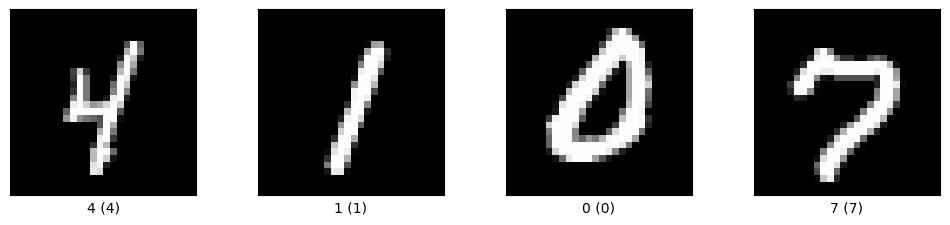

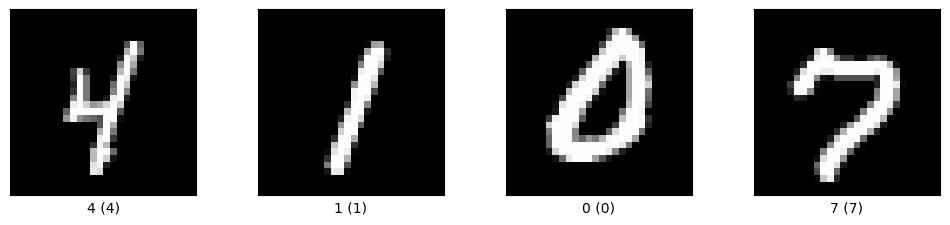

In [237]:
tfds.show_examples(train_ds, ds_info, rows=1, cols=4)

In [238]:
def dataset(ds, mini_batch_size=512):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 128.0 - 1, y))
    ds = ds.map(lambda x, y: (tf.reshape(x, (-1,)), y))
    ds = ds.map(lambda x, y: (x, tf.one_hot(y, 10)))
    ds = ds.shuffle(10000).batch(mini_batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

ds = dataset(train_ds)
for elem in ds.take(1):
    print(elem)

2023-11-19 19:06:33.542250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-11-19 19:06:33.542757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


(<tf.Tensor: shape=(512, 784), dtype=float32, numpy=
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)>, <tf.Tensor: shape=(512, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>)


2023-11-19 19:06:33.907639: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [239]:
class Model(tf.keras.Model):
    def __init__(self, dense_layers, output_shape, layers_activation, output_activation):
        super(Model, self).__init__()
        self.__layers = []
        for layer in dense_layers:
            self.__layers.append(tf.keras.layers.Dense(layer, activation=layers_activation))
        self.__layers.append(tf.keras.layers.Dense(output_shape, activation=output_activation))

    def call(self, inputs):
        x = inputs
        for layer in self.__layers:
            x = layer(x)
        return x

In [240]:
from tqdm import tqdm

def training_loop(model, train, test, loss, opt, epochs=100):
    train_loss = tf.keras.metrics.Mean()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_loss = tf.keras.metrics.Mean()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()

    metrics = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
    }

    for epoch in tqdm(range(epochs), desc='Epochs'):
        for x, y in train:
            with tf.GradientTape() as tape:
                y_pred = model(x)
                loss_value = loss(y, y_pred)
            grads = tape.gradient(loss_value, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))
            
            train_loss(loss_value)
            train_accuracy(y, y_pred)
        
        for x, y in test:
            y_pred = model(x)
            loss_value = loss(y, y_pred)
            
            test_loss(loss_value)
            test_accuracy(y, y_pred)

        metrics['train_loss'].append(train_loss.result().numpy())
        metrics['train_accuracy'].append(train_accuracy.result().numpy())
        metrics['test_loss'].append(test_loss.result().numpy())
        metrics['test_accuracy'].append(test_accuracy.result().numpy())

        print(f'Train Loss: {metrics["train_loss"][-1]:.4f}, Train Accuracy: {metrics["train_accuracy"][-1]:.4f}')
        print(f'Test Loss: {metrics["test_loss"][-1]:.4f}, Test Accuracy: {metrics["test_accuracy"][-1]:.4f}')
        print()
    
    return metrics


In [331]:
import matplotlib.pyplot as plt

def visualize(metrics, fig_title = "",max_steps = 20):

    epoch_idx = range(len(metrics['test_loss']))
    x_ticks = list(range(len(metrics['test_loss'])))
    x_ticks = x_ticks[::len(x_ticks)//max_steps + 1]

    # Create a figure with two subplots (axes)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(fig_title)

    # Plot test loss and accuracy
    line3, = ax1.plot(metrics['test_loss'], 'r-')
    line4, = ax1.plot(metrics['train_loss'], 'b-')

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend([line3, line4], ['Test Loss', 'Train Loss'])
    ax1.set_title('Loss, Train - Test')
    ax1.set_xticks(x_ticks)
    ax1.grid(True)

    # Plot training loss and accuracy
    line1, = ax2.plot(metrics['test_accuracy'], 'r--')
    line2, = ax2.plot(metrics['train_accuracy'], 'b--')

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend([line1, line2], ['Test Accuracy', 'Train Accuracy'])
    ax2.set_title('Accuracy, Train - Test')
    ax2.set_xticks(x_ticks)
    ax2.grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()

def plot_model_comparision(models):
    fig , ax = plt.subplots(1, 1, figsize=(8, 4))
    fig.suptitle("Model Comparision")


    if len(models) > 1:
        for model in models:
            model_info = load_metrics(model)
            model_metrics = model_info['metrics']
            model_hyper_parameter = model_info['hyper_parameter']
            ax.plot(model_metrics['test_accuracy'], label=model_info['description'])
    else:
        model_info = load_metrics(models)
        model_metrics = model_info['metrics']
        model_hyper_parameter = model_info['hyper_parameter']
        ax.plot(model_metrics['test_accuracy'], label=model_info['description'])

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()

    plt.tight_layout()
    plt.show()

In [242]:
# model = Model(dense_layers=[128], output_shape=10, layers_activation='relu', output_activation='softmax')
# loss = tf.keras.losses.CategoricalCrossentropy()
# opt = tf.keras.optimizers.SGD(learning_rate=0.1)

# metrics = training_loop(model, dataset(train_ds), dataset(test_ds), loss, opt, 10)
# visualize(metrics)

### Hyperparameters

In [243]:
import json
import numpy as np

def save_metrics(model, metrics, hyper_parameter, file_name='metrics.json', model_description=""):
    for key, value in metrics.items():
        metrics[key] = [np.around(float(x), 4) for x in value]
    
    params = model.count_params()
    model_info = {
                "description": model_description ,
                "parameter_count": params,
                "hyper_parameter": hyper_parameter,
                "metrics": metrics,
                "accuracy_test": metrics['test_accuracy'][-1],
                "accuracy_train": metrics['train_accuracy'][-1],
                "loss_test": metrics['test_loss'][-1],
                "loss_train": metrics['train_loss'][-1],
                }
    with open(file_name, 'w') as f:
        json.dump(model_info, f)

def load_metrics(file_name='metrics.json'):
    with open(file_name, 'r') as f:
        model_info = json.load(f)
    return model_info
    

In [244]:
class ModelHyper(tf.keras.Model):
    def __init__(self):
        super(ModelHyper, self).__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Conv2D(8, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax'),
        ])

    def call(self, inputs):
        x = tf.reshape(inputs, [-1, 28, 28, 1])
        return self.seq(x)

In [370]:
DENSE_LAYERS = [64]
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.01
MOMENTUM = 0.5
USE_SCHEDULER = True

train_data = dataset(train_ds, BATCH_SIZE)
test_data = dataset(test_ds, BATCH_SIZE)

In [371]:
model = Model(DENSE_LAYERS, 10, 'relu', 'softmax')
# model = ModelHyper()

loss = tf.keras.losses.CategoricalCrossentropy()
if USE_SCHEDULER:
    lr_fn = tf.optimizers.schedules.PolynomialDecay(LEARNING_RATE*0.1, EPOCHS, LEARNING_RATE*10, 2)
    opt = tf.keras.optimizers.SGD(learning_rate=lr_fn, momentum=MOMENTUM)
    # opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
else:
    opt = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM)
    # opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [372]:
metrics = training_loop(model, train_data, test_data, loss, opt, EPOCHS)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

2023-11-19 20:02:01.481635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-11-19 20:02:01.482780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-11-19 20:02:07.325765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{no

Train Loss: 0.5173, Train Accuracy: 0.8408
Test Loss: 0.2797, Test Accuracy: 0.9148



Epochs:  20%|██        | 2/10 [00:12<00:49,  6.23s/it]

Train Loss: 0.3852, Train Accuracy: 0.8829
Test Loss: 0.2402, Test Accuracy: 0.9273



Epochs:  30%|███       | 3/10 [00:18<00:43,  6.21s/it]

Train Loss: 0.3254, Train Accuracy: 0.9018
Test Loss: 0.2234, Test Accuracy: 0.9327



Epochs:  40%|████      | 4/10 [00:25<00:37,  6.27s/it]

Train Loss: 0.2878, Train Accuracy: 0.9133
Test Loss: 0.2164, Test Accuracy: 0.9340



Epochs:  50%|█████     | 5/10 [00:31<00:31,  6.26s/it]

Train Loss: 0.2618, Train Accuracy: 0.9213
Test Loss: 0.2033, Test Accuracy: 0.9383



Epochs:  60%|██████    | 6/10 [00:37<00:24,  6.22s/it]

Train Loss: 0.2421, Train Accuracy: 0.9274
Test Loss: 0.1971, Test Accuracy: 0.9403



Epochs:  70%|███████   | 7/10 [00:43<00:18,  6.31s/it]

Train Loss: 0.2268, Train Accuracy: 0.9321
Test Loss: 0.1872, Test Accuracy: 0.9431



Epochs:  80%|████████  | 8/10 [00:50<00:12,  6.40s/it]

Train Loss: 0.2143, Train Accuracy: 0.9359
Test Loss: 0.1821, Test Accuracy: 0.9447



Epochs:  90%|█████████ | 9/10 [00:56<00:06,  6.41s/it]

Train Loss: 0.2036, Train Accuracy: 0.9391
Test Loss: 0.1772, Test Accuracy: 0.9463



Epochs: 100%|██████████| 10/10 [01:03<00:00,  6.35s/it]

Train Loss: 0.1945, Train Accuracy: 0.9418
Test Loss: 0.1737, Test Accuracy: 0.9475



In [364]:
print(model.summary())

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_133 (Dense)           multiple                  50240     
                                                                 
 dense_134 (Dense)           multiple                  650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________
None


In [373]:
hyper_parameter = {
    'DENSE_LAYERS': DENSE_LAYERS,
    'EPOCHS': EPOCHS,
    'BATCH_SIZE': BATCH_SIZE,
    'LEARNING_RATE': LEARNING_RATE,
    'MOMENTUM': MOMENTUM,
    'USE_SCHEDULER': USE_SCHEDULER,
    'OPTIMIZER': 'SGD'
}

file_name = 'metrics_07.json'
model_description = f"Dense_{len(DENSE_LAYERS)}"
# model_description = "CNN_2Conv_2MaxPool_1Dense"
save_metrics(model, metrics, hyper_parameter, file_name ,model_description)

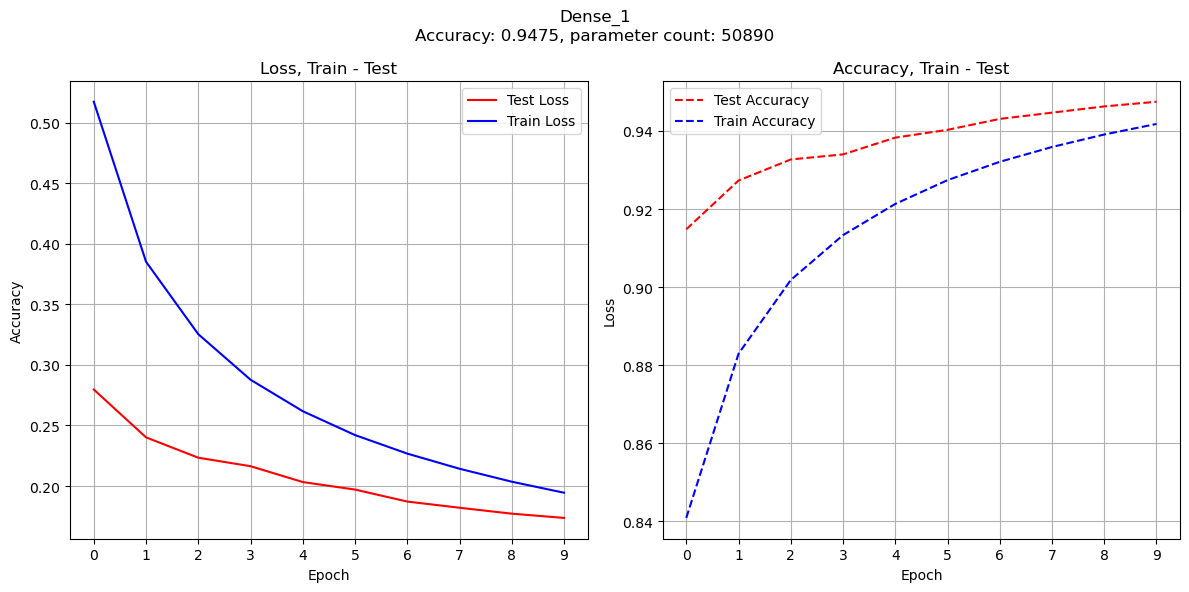

In [375]:
with open(file_name, 'r') as f:
    model_info = json.load(f)

visualize(model_info['metrics'],
 f"{model_info['description']}\nAccuracy: {model_info['accuracy_test']:.4f}, parameter count: {model_info['parameter_count']}")


                       model         layers #params     lr  momentum mini_batch epochs optimizer  accuracy_test  accuracy_train
0  CNN_2Conv_2MaxPool_1Dense             []   71786  0.010       0.9        512     10      adam         0.9858          0.9825
4  CNN_2Conv_2MaxPool_1Dense             []   71786  0.010       0.9        512     10       SGD         0.9850          0.9735
5                    Dense_1          [128]  101770  0.010       0.9        512     10       SGD         0.9487          0.9459
7                    Dense_1           [64]   50890  0.010       0.5        128     10       SGD         0.9475          0.9418
2                    Dense_3  [128, 64, 32]  111146  0.001       0.9        512     10       SGD         0.9437          0.9238
3                    Dense_1           [64]   50890  0.010       0.9        256     10       SGD         0.9431          0.9389
6                    Dense_1           [64]   50890  0.010       0.5        256     10       SGD        

/tmp/ipykernel_32609/1106695021.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_entry_df], ignore_index=True)


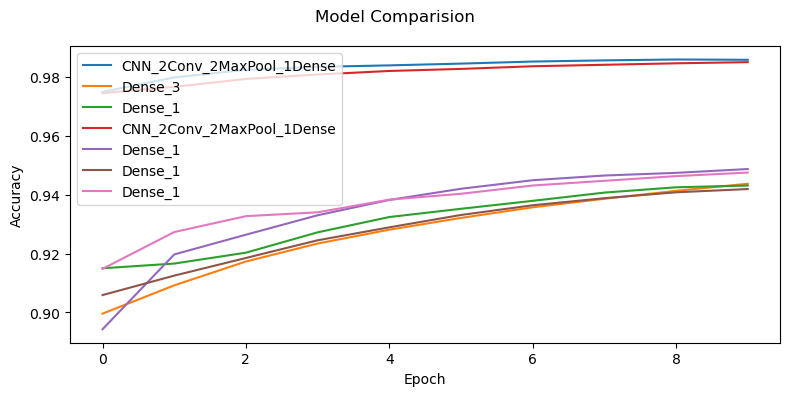

In [376]:
import pandas as pd

model_comparision = ["metrics_00.json","metrics_01.json", "metrics_02.json", "metrics_03.json","metrics_04.json", "metrics_05.json", "metrics_06.json", "metrics_07.json"]

# Define columns for the DataFrame
columns = ['model', 'layers', '#params', 'lr', 'momentum', 'mini_batch', 'epochs', 'optimizer', 'accuracy_test', 'accuracy_train']
df = pd.DataFrame(columns=columns)

for model in model_comparision:
    model_info = load_metrics(model)
    model_hyper_parameter = model_info['hyper_parameter']

    # Create a new entry as a dictionary ensuring all columns are covered
    new_entry = {
        'model': model_info['description'],
        'layers': model_hyper_parameter.get('DENSE_LAYERS', pd.NA),  # Using pd.NA for missing values
        '#params': model_info['parameter_count'],
        'lr': model_hyper_parameter.get('LEARNING_RATE', pd.NA),
        'momentum': model_hyper_parameter.get('MOMENTUM', pd.NA),
        'mini_batch': model_hyper_parameter.get('BATCH_SIZE', pd.NA),
        'epochs': model_hyper_parameter.get('EPOCHS', pd.NA),
        'optimizer': model_hyper_parameter.get('OPTIMIZER', pd.NA),
        'accuracy_test': model_info.get('accuracy_test', pd.NA),
        'accuracy_train': model_info.get('accuracy_train', pd.NA)
    }

    # Convert the dictionary to a DataFrame and concatenate
    new_entry_df = pd.DataFrame([new_entry], columns=columns)
    df = pd.concat([df, new_entry_df], ignore_index=True)

df = df.sort_values(by=['accuracy_test'], ascending=False)
print(df.to_string())

plot_model_comparision([model_comparision[0]] + model_comparision[2:])